In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import random

**Getting the DataSet**

In [ ]:
string_list = list(string.ascii_uppercase + string.ascii_lowercase + string.digits)

data_map = {}

#We map the respective
for char in string_list:

  # The files are named according to hexadecimal
  data_map[char] = os.listdir(f"data/by_class/{format(ord(char), 'x')}/hsf_0")


In [ ]:
all_samples = []

for char, file_list in data_map.items():
    for filename in file_list:
      for i in range(3):
        img_path = f"/content/nist_data/by_class/{format(ord(char), 'x')}/hsf_{i}/{filename}"
        if os.path.exists(img_path):  # Check if the file exists
                all_samples.append((char, img_path))
                break  # If found in one hsf folder, no need to check others

random.shuffle(all_samples)

In [ ]:
total = len(all_samples)
train_end = int(0.7 * total)
val_end = int(0.9 * total)

#Making our splits
train_data = all_samples[:train_end]
val_data = all_samples[train_end:val_end]
test_data = all_samples[val_end:]


In [ ]:
class NISTDataset(Dataset):
    def __init__(self, data, transform=None, label_map=None):
        self.data = data
        self.transform = transform

        all_chars = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
        self.label_map = {char: idx for idx, char in enumerate(all_chars)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_char, img_path = self.data[idx]
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label_char]
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values to range [-1, 1]
])


train_dataset = NISTDataset(train_data, transform=transform)
test_dataset = NISTDataset(test_data, transform=transform)
val_dataset = NISTDataset(val_data, transform=transform)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

**Defining the Convolutional Neural Network**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 62)
        self.relu = nn.ReLU()

    def forward(self, x, drop_prob=0.5):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=drop_prob, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=drop_prob, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=drop_prob, training=self.training)
        x = self.fc4(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4) # L2 regularization

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the selected device
model = CNN().to(device)


Using device: cuda


**Training the model**

In [ ]:
num_epochs = 10
loss_hist = []
test_loss = []


for epoch in range(num_epochs):
  model.train()
  with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:

      optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)

      for batch_idx, (images, labels) in pbar:
          optimizer.zero_grad() # Reset the gradients after each batch

          images, labels = images.to(device), labels.to(device) # Move to gpu

          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward() # Computes the gradients of the losses
          optimizer.step() # Updates the parameters

          pbar.set_postfix(loss=loss.item())

          loss_hist.append(loss.item())

  model.eval()
  with torch.no_grad(): # Environment without gradient calculation
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device) # Move to gpu

          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss.append(loss.item())
          pbar.set_postfix(test_loss=loss.item())



Epoch 10/10: 100%|██████████| 477/477 [02:26<00:00,  3.26it/s, loss=0.163]


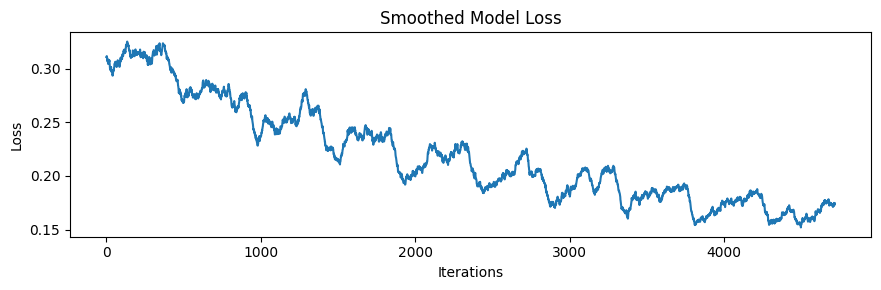

In [ ]:
def moving_average(x, window_size=50):
    return [sum(x[i:i+window_size])/window_size for i in range(len(x)-window_size)]

smoothed_loss = moving_average(loss_hist)

plt.figure(figsize=(9, 3))
plt.plot(smoothed_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Smoothed Model Loss")
plt.tight_layout()
plt.show()

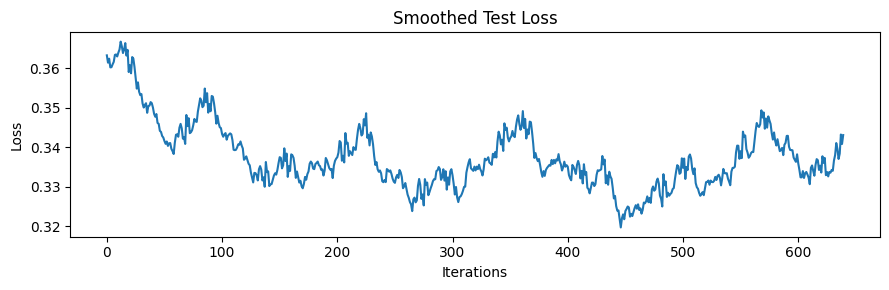

In [ ]:
def moving_average(x, window_size=50):
    return [sum(x[i:i+window_size])/window_size for i in range(len(x)-window_size)]

smoothed_loss = moving_average(test_loss)

plt.figure(figsize=(9, 3))
plt.plot(smoothed_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Smoothed Test Loss")
plt.tight_layout()
plt.show()

**Testing the model**

In [ ]:
correct = 0
total = 0

with torch.no_grad(): # Environment without gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) # Move to gpu
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 89.76%


**Saving the weights**

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')